In [1]:
import json
import os
import pickle

import matplotlib.pyplot as plt
import torch


colors = ["red", "teal", "gold", "green", "red", "teal", "gold", "green"]

In [2]:
def load_data_navier_stokes(directory: str) -> dict:
    data = {}
    import numpy as np

    def jax_to_torch(jax_array):
        if isinstance(jax_array, dict):
            return {k: torch.tensor(np.array(v)) for k, v in jax_array.items()}
        return torch.tensor(np.array(jax_array))

    data["observation_grid"] = jax_to_torch(pickle.load(open(os.path.join(directory, "time.pickle"), "rb")))
    data["observation_values"] = jax_to_torch(pickle.load(open(os.path.join(directory, "u_and_v_time_coefficients.pickle"), "rb")))
    data["high_dim_trajectory"] = jax_to_torch(pickle.load(open(os.path.join(directory, "u_and_v.pickle"), "rb")))
    data["imputation_mask"] = jax_to_torch(pickle.load(open(os.path.join(directory, "imputation_mask_0_2_perc.pickle"), "rb")))
    data["observation_mask"] = jax_to_torch(pickle.load(open(os.path.join(directory, "observation_mask_0_2_perc.pickle"), "rb")))
    data["pca_params"] = jax_to_torch(pickle.load(open(os.path.join(directory, "u_and_v_pca_params.pickle"), "rb")))
    B, T = data["observation_values"].size(0), data["observation_values"].size(1)
    data["high_dim_trajectory"] = data["high_dim_trajectory"].reshape(B, T, -1)

    return data


ground_truth_data = load_data_navier_stokes(
    "/cephfs_projects/foundation_models/data/ODE/test/navier_stokes_preprocessed_with_imputation_sets_and_train_test_split/split_single_long/"
)
print(list(ground_truth_data.keys()))

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


['observation_grid', 'observation_values', 'high_dim_trajectory', 'imputation_mask', 'observation_mask', 'pca_params']


In [ ]:
base_path = "/home/cvejoski/Projects/FoundationModels/FIM/reports/FIMImputation/NavierStokes/09-26-2014_overlap0-random_window-interpolated-10-30-soulution/"
predictions_high_dim = torch.load(base_path + "high_dim_predictions.pth")
predictions_pca = torch.load(base_path + "pca_predictions.pth")

In [6]:
for k, v in predictions_pca.items():
    for ki, vi in v.items():
        print(f"{k:18} {ki:15} : {vi.shape}")

print("---")
# for k, v in predictions_high_dim.items():
#     for ki, vi in v.items():
#         print(f"{k:18} {ki:15} : {vi.shape}")

B, wc, wlen, _ = predictions_pca["observations"]["values"].shape

imputation_window  learnt          : torch.Size([61, 8, 38])
imputation_window  target          : torch.Size([61, 8, 38])
imputation_window  locations       : torch.Size([61, 8, 1])
imputation_window  drift           : torch.Size([61, 8, 38])
imputation_window  drift_certainty : torch.Size([61, 8, 38])
imputation_window  padding_mask_locations : torch.Size([61, 8])
observations       values          : torch.Size([61, 4, 40, 38])
observations       mask            : torch.Size([61, 4, 40, 1])
observations       times           : torch.Size([61, 4, 40, 1])
observations       denoised_values : torch.Size([61, 4, 40, 38])
observations       interpolation   : torch.Size([61, 4, 40, 38])
observations       drift           : torch.Size([61, 4, 40, 38])
observations       drift_certainty : torch.Size([61, 4, 40, 38])
---


# Visualizations

In [7]:
# get 16 random samples
torch.manual_seed(0)
# unique sample ids
sample_ids = sorted(torch.randperm(B)[:16])
sample_ids = [v.item() for v in sample_ids]
print(sample_ids)

[9, 13, 27, 30, 34, 40, 41, 43, 44, 48, 52, 53, 56, 57, 59, 60]


In [8]:
def plot_sample(line_plot_data: dict, sample_id: int, dim: int, ax, plot_imputation=True, plot_observations: bool = True):
    batch_size, observed_window_count, _, _ = line_plot_data["observations"]["values"].shape

    if plot_imputation:
        imputation_times = line_plot_data["imputation_window"]["locations"][sample_id].cpu()
        imputation_target = line_plot_data["imputation_window"]["target"][sample_id, :, dim].cpu()
        imputation_learnt = line_plot_data["imputation_window"]["learnt"][sample_id, :, dim].cpu()

    for i in range(observed_window_count):
        if plot_observations:
            obs_mask = line_plot_data["observations"]["mask"][sample_id, i, :, 0].cpu()
            obs_times = line_plot_data["observations"]["times"][sample_id, i, :, 0][~obs_mask].cpu()
            obs_values = line_plot_data["observations"]["values"][sample_id, i, :, dim][~obs_mask].cpu()
            obs_interpolation = line_plot_data["observations"]["interpolation"][sample_id, i, :, dim][~obs_mask].cpu()

            ax.scatter(obs_times, obs_values, color=colors[i], marker="x", label=f"observed window {i}")
            ax.plot(obs_times, obs_interpolation, color="black", linestyle="--", label=f"interpolation {i}")
    if plot_imputation:
        ax.plot(imputation_times, imputation_target, color="black", linestyle=":", label="target")
        ax.plot(imputation_times, imputation_learnt, color="blue", label="learnt")
    # axs[0].legend()
    ax.set_title(f"{sample_id}, dim {dim}")
    ax.set_xlabel("Time")

    # remove spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)


def plot_drift_sample(line_plot_data: dict, sample_id: int, dim: int, ax):
    obs_mask = line_plot_data["observations"]["mask"][sample_id, ..., 0].cpu()
    drift_obs = line_plot_data["observations"]["drift"][sample_id, ..., dim].cpu()
    drift_certainty_obs = line_plot_data["observations"]["drift_certainty"][sample_id, ..., dim].cpu()
    times_obs = line_plot_data["observations"]["times"][sample_id, ..., 0].cpu()

    imp_mask = line_plot_data["imputation_window"]["padding_mask_locations"][sample_id].cpu()
    drift_imp = line_plot_data["imputation_window"]["drift"][sample_id, :, dim][~imp_mask].cpu()
    drift_certainty_imp = line_plot_data["imputation_window"]["drift_certainty"][sample_id, :, dim][~imp_mask].cpu()
    imputation_times = line_plot_data["imputation_window"]["locations"][sample_id, :, 0][~imp_mask].cpu()

    for w in range(drift_obs.size(0)):
        ax.plot(times_obs[w][~obs_mask[w]], drift_obs[w][~obs_mask[w]], color=colors[w], linestyle="-", label=f"observed window {w}")
        ax.fill_between(
            times_obs[w][~obs_mask[w]],
            drift_obs[w][~obs_mask[w]] - drift_certainty_obs[w][~obs_mask[w]],
            drift_obs[w][~obs_mask[w]] + drift_certainty_obs[w][~obs_mask[w]],
            alpha=0.3,
            color=colors[w],
        )
    ax.plot(imputation_times, drift_imp, color="blue", label="learnt")
    ax.fill_between(
        imputation_times.squeeze(-1),
        drift_imp - drift_certainty_imp,
        drift_imp + drift_certainty_imp,
        alpha=0.3,
        color="blue",
        label="certainty",
    )
    ax.set_title(f"Drift {sample_id}, dim {dim}")

    # remove spines
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

## High Dim

In [9]:
B, wc, wlen, D = predictions_high_dim["observations"]["values"].shape

dims = [v.item() for v in sorted(torch.randint(0, D, (16,)))]


fig, axs = plt.subplots(4, 4, figsize=(15, 15))

for ax, sample_id, dim in zip(axs.flatten(), sample_ids, dims):
    plot_sample(predictions_high_dim, sample_id, dim=dim, ax=ax, plot_observations=True, plot_imputation=True)
fig.suptitle("Imputation")
axs[0, 0].legend()
plt.tight_layout()
plt.savefig(base_path + "imputation_high_dim.png")
plt.show()

NameError: name 'predictions_high_dim' is not defined

In [10]:
predictions_high_dim["observations"]["values"][24, 0, :, 25]

NameError: name 'predictions_high_dim' is not defined

# PCA space

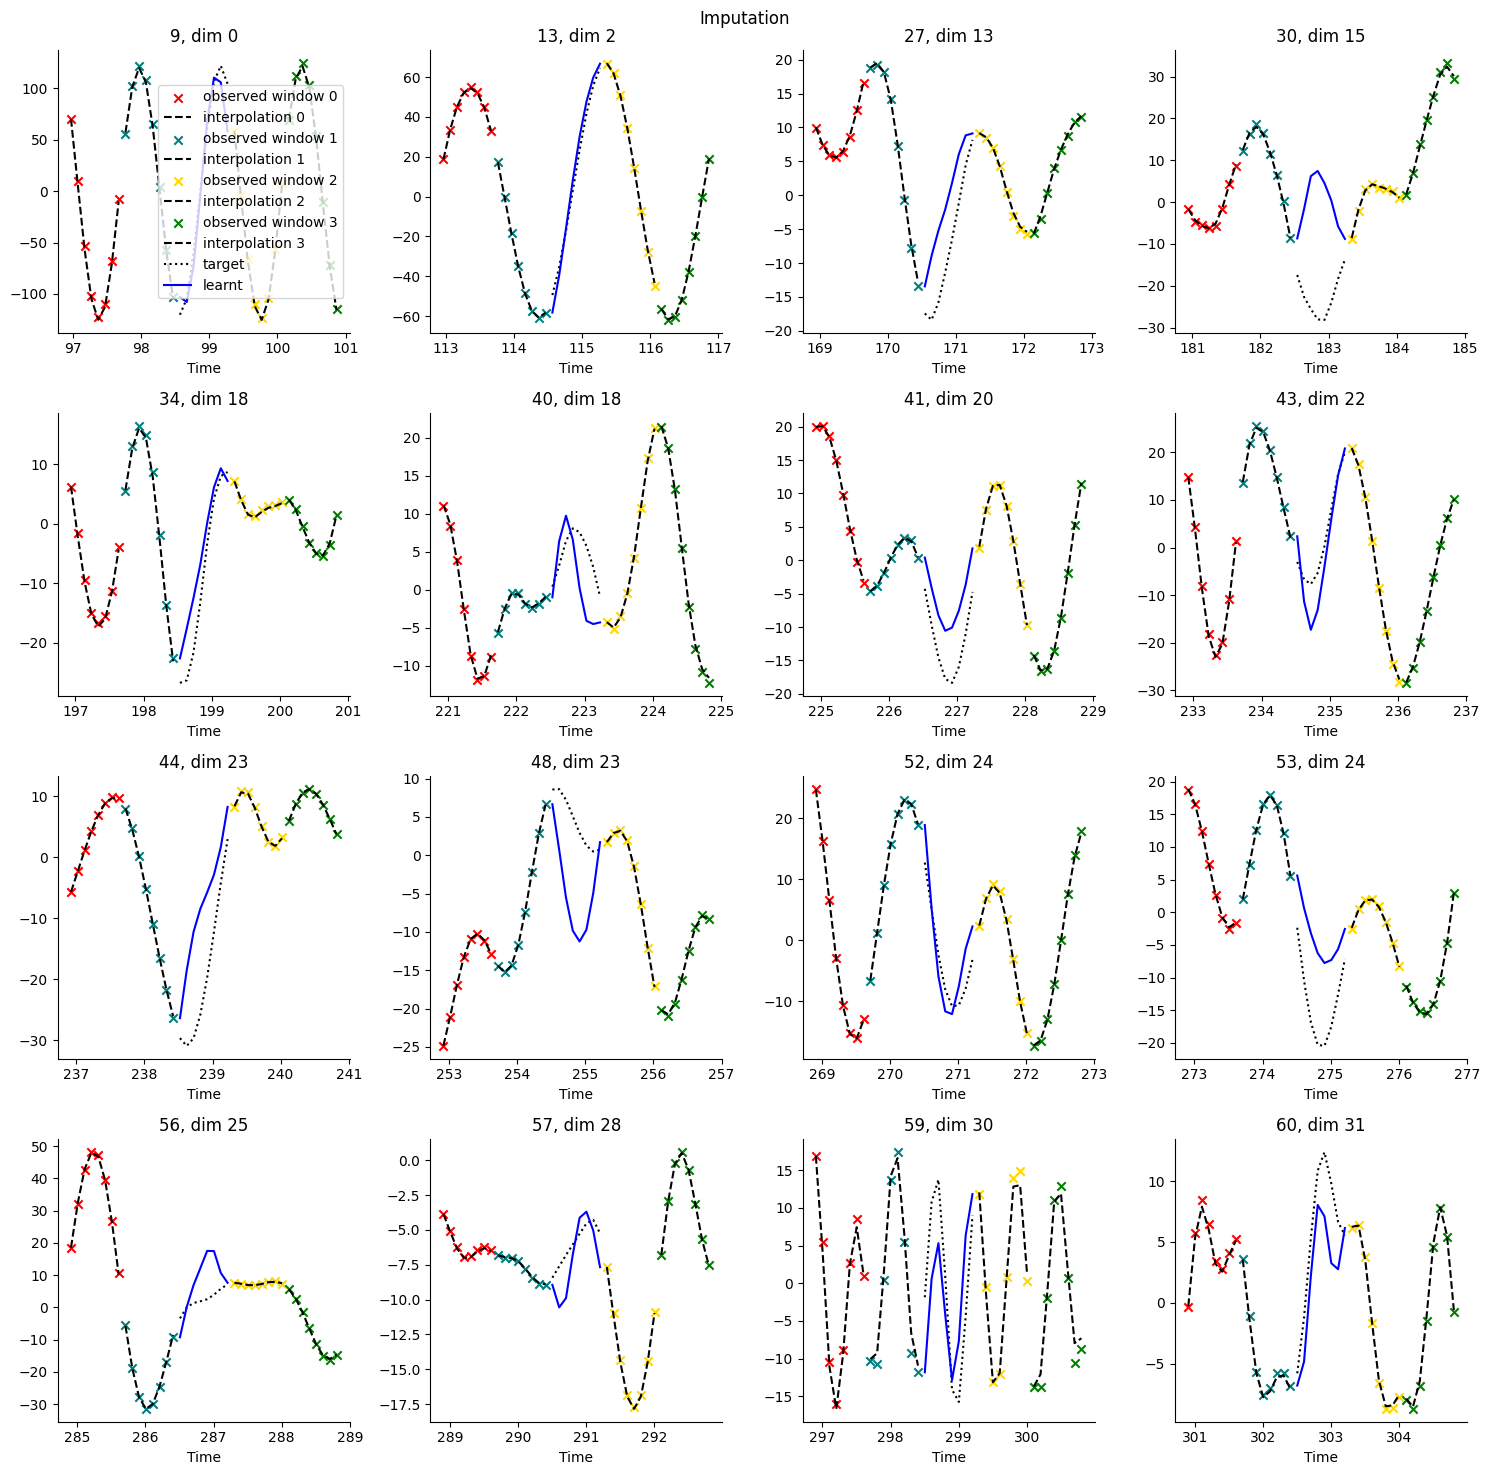

In [11]:
B, wc, wlen, D = predictions_pca["observations"]["values"].shape

dims = [v.item() for v in sorted(torch.randint(0, D, (16,)))]


fig, axs = plt.subplots(4, 4, figsize=(15, 15))

for ax, sample_id, dim in zip(axs.flatten(), sample_ids, dims):
    plot_sample(predictions_pca, sample_id, dim=dim, ax=ax, plot_observations=True, plot_imputation=True)
fig.suptitle("Imputation")
axs[0, 0].legend()
plt.tight_layout()
plt.savefig(base_path + "imputation_pca.png")
plt.show()

# Metrics

In [12]:
metrics_high_dim: dict = json.load(open(base_path + "high_dim_metrics.json", "r"))
print("metrics_high_dim")
print(json.dumps(metrics_high_dim, indent=2))

FileNotFoundError: [Errno 2] No such file or directory: '/home/cvejoski/Projects/FoundationModels/FIM/reports/FIMImputation/NavierStokes/09-26-2014_overlap0-random_window-interpolated-10-30-soulution/high_dim_metrics.json'

In [13]:
metrics_pca: dict = json.load(open(base_path + "pca_metrics.json", "r"))
print("metrics_pca")
print(json.dumps(metrics_pca, indent=2))

metrics_pca
{
  "r2_score_mean": -2.9321932792663574,
  "r2_score_std": 1.0954136848449707,
  "r2_score_above0.9": 0.0,
  "mae_mean": 0.06246320903301239,
  "mae_std": 0.0032540245447307825,
  "mse_mean": 0.01072714664041996,
  "mse_std": 0.0010073566809296608,
  "rmse_mean": 0.10346069931983948,
  "rmse_std": 0.004838753957301378,
  "manual_mse_mean": 0.01072714664041996,
  "manual_mse_std": 0.0010073567973449826,
  "manual_rmse_mean": 0.10346069931983948,
  "manual_rmse_std": 0.0048387558199465275
}


# plot single samples

In [ ]:
# get sample id of worst performing prediction
predictions = predictions_pca  # or predictions_pca
performance = ((predictions["imputation_window"]["target"] - predictions["imputation_window"]["learnt"]) ** 2).mean(dim=1).mean(dim=1)
print("performance per sample")
print(performance)
print(performance.mean())
print(torch.sqrt(performance.mean()))

In [ ]:
(predictions["imputation_window"]["target"][0, :-8, :] - predictions["imputation_window"]["learnt"][0, :-8, :]).mean(dim=0).mean(dim=0)

In [ ]:
# random sample
sample_id = 2
dim = 0
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plot_sample(predictions, sample_id, dim, axs[0])
axs[0].legend(ncols=3, loc="upper left", bbox_to_anchor=(-0.1, -0.15))
plot_drift_sample(predictions, sample_id, dim, axs[1])

fig.suptitle("Random sample")
plt.tight_layout()
plt.savefig(base_path + f"sample{sample_id}.png")
plt.show()

In [ ]:
# worst performing sample
worst_sample_id = performance.argmax().item()

# plot worst performing sample
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plot_sample(predictions, worst_sample_id, 2, axs[0])
axs[0].legend(ncols=3, loc="upper left", bbox_to_anchor=(-0.1, -0.15))

plot_drift_sample(predictions, worst_sample_id, 2, axs[1])
fig.suptitle("Worst performing sample")
plt.tight_layout()
plt.savefig(base_path + f"worst_sample{worst_sample_id}.png")

# second worst performing sample
second_worst_sample_id = performance.argsort()[1].item()

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plot_sample(predictions, second_worst_sample_id, 2, axs[0])
axs[0].legend(ncols=3, loc="upper left", bbox_to_anchor=(-0.1, -0.15))
plot_drift_sample(predictions, second_worst_sample_id, 2, axs[1])
fig.suptitle("Second worst performing sample")
plt.tight_layout()
plt.savefig(base_path + f"second_worst_sample{second_worst_sample_id}.png")
plt.show()

# best performing sample
best_sample_id = performance.argmin().item()

# plot best performing sample
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plot_sample(predictions, best_sample_id, 2, axs[0])
axs[0].legend(ncols=3, loc="upper left", bbox_to_anchor=(-0.1, -0.15))

plot_drift_sample(predictions, best_sample_id, 2, axs[1])
fig.suptitle("Best performing sample")
plt.tight_layout()
plt.savefig(base_path + f"best_sample{best_sample_id}.png")
plt.show()